In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

## Load and process the data

In [2]:
df_rndbkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [3]:
dt = df_rndbkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
    

correct = (dt[:,0]>=2800)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]
dt = dt[bkg_idx]
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [4]:
dt.shape

(587907, 36)

In [5]:
Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [6]:
Y.shape

(587907, 12)

In [7]:
    
#if whichbkg == 'rndbkg':
#    dt = df_rndbkg.values
#    correct = (dt[:,3]>0) &(dt[:,19]>0) &(dt[:,1]>0) &(dt[:,2]>0)&(dt[:,16]>0)&(dt[:,32]>0)
#    dt = dt[correct]
#    for i in range(13,19):
#        dt[:,i] = dt[:,i]/dt[:,3]
#    
#    for i in range(29,35):
#        dt[:,i] = dt[:,i]/(dt[:,19])
#        
#    correct = (dt[:,16]>0) &(dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#    dt = dt[correct]   
#    correct = (dt[:,0]>=2800)
#    dt = dt[correct]
#    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#    idx = dt[:,-1]
#    bkg_idx = np.where(idx==0)[0]
#    signal_idx = np.where(idx==1)[0]
#    dt = dt[bkg_idx]
#    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#    Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [8]:
bkg_mean = []
bkg_std = []

In [9]:
for i in range(12):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    bkg_mean.append(mean)
    bkg_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

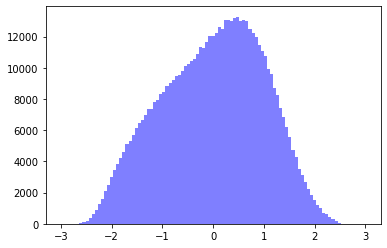

In [10]:
bins = np.linspace(-3,3,100)
bins.shape
column = 1
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [11]:
bkg_mean

[229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

# Do architecture optimization with beta, zdim, nflow 

# CHOOSE BEST ARCHITECTURE< TRY DIFFERENT NORMALIZING FLOW MODELS

In [12]:
bkg_std

[131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]

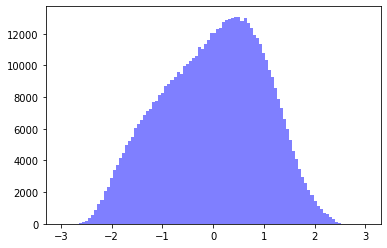

In [13]:
bins = np.linspace(-3,3,101)
plt.hist(Y[:,1],bins,alpha=0.5,color='b');

In [14]:
total_PureBkg = torch.tensor(Y)

total_PureBkg_selection = total_PureBkg

In [15]:
total_PureBkg_selection.shape

torch.Size([587907, 12])

In [16]:
bs = 800
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [17]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [18]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 1
Z_DIM = 8

n_steps = 0

In [19]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-8)

In [21]:
beta = 1

In [22]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        
        
        
        mseloss = nn.MSELoss(size_average=False)
        
        huberloss = nn.SmoothL1Loss(size_average=False)
        

        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [23]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            huberloss = nn.SmoothL1Loss(size_average=False)
        

            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [24]:
print(beta)

1


In [25]:
print(model)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=20, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=30, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=50, out_features=12, bias=True)
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): MAF(
        (layers): ModuleList(
          (0): FCNN(
            (network): Sequential(
              (0): Linear(in_features=1, out_features=8

In [26]:
'''
ae_def = {
    "type":"bkg",
    "trainon":"purebkg",
    "features":"tauDDTwithrawmass",
    "architecture":"MAF",
    "selection":"turnoncutandj1sdbcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z6f10",
}
'''

'\nae_def = {\n    "type":"bkg",\n    "trainon":"purebkg",\n    "features":"tauDDTwithrawmass",\n    "architecture":"MAF",\n    "selection":"turnoncutandj1sdbcut",\n    "trainloss":"MSELoss",\n    "beta":"beta1",\n    "zdimnflow":"z6f10",\n}\n'

In [43]:
ae_def = {
    "type":"bkg",
    "trainon":"rndbkg",
    "features":"12features",
    "architecture":"MAF",
    "selection":"mjjcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z8f1",
}

In [44]:
model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

In [62]:
N_EPOCHS = 10
#BEST_LOSS = 99
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
    
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: -89.2857 Time: 2.604 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -89.2915 Time: 2.603 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -89.2896 Time: 2.604 s
Not saving model! Last saved: 2
Epoch 4:

Evaluation Completed (valid)!	Loss: -89.3327 Time: 2.629 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -89.3087 Time: 2.599 s
Not saving model! Last saved: 4
Epoch 6:

Evaluation Completed (valid)!	Loss: -89.3469 Time: 2.602 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -89.3468 Time: 2.628 s
Not saving model! Last saved: 6
Epoch 8:

Evaluation Completed (valid)!	Loss: -89.3658 Time: 2.607 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -89.3525 Time: 2.602 s
Not saving model! Last saved: 8
Epoch 10:

Evaluation Completed (valid)!	Loss: -89.3997 Time: 2.603 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -89.3951 Time: 2.603 s
Not saving model! Last save


Evaluation Completed (valid)!	Loss: -89.9716 Time: 2.604 s
Saving model!
Epoch 88:

Evaluation Completed (valid)!	Loss: -89.9004 Time: 2.605 s
Not saving model! Last saved: 87
Epoch 89:

Evaluation Completed (valid)!	Loss: -89.9635 Time: 2.598 s
Not saving model! Last saved: 87
Epoch 90:

Evaluation Completed (valid)!	Loss: -89.9260 Time: 2.600 s
Not saving model! Last saved: 87
Epoch 91:

Evaluation Completed (valid)!	Loss: -89.9811 Time: 2.608 s
Saving model!
Epoch 92:

Evaluation Completed (valid)!	Loss: -89.9553 Time: 2.640 s
Not saving model! Last saved: 91
Epoch 93:

Evaluation Completed (valid)!	Loss: -89.9230 Time: 2.641 s
Not saving model! Last saved: 91
Epoch 94:

Evaluation Completed (valid)!	Loss: -89.9240 Time: 2.615 s
Not saving model! Last saved: 91
Epoch 95:

Evaluation Completed (valid)!	Loss: -89.9666 Time: 2.616 s
Not saving model! Last saved: 91
Epoch 96:

Evaluation Completed (valid)!	Loss: -90.0291 Time: 2.606 s
Saving model!
Epoch 97:

Evaluation Completed (vali


Evaluation Completed (valid)!	Loss: -90.4093 Time: 2.612 s
Not saving model! Last saved: 167
Epoch 171:

Evaluation Completed (valid)!	Loss: -90.3909 Time: 2.610 s
Not saving model! Last saved: 167
Epoch 172:

Evaluation Completed (valid)!	Loss: -90.4118 Time: 2.640 s
Not saving model! Last saved: 167
Epoch 173:

Evaluation Completed (valid)!	Loss: -90.4396 Time: 2.601 s
Not saving model! Last saved: 167
Epoch 174:

Evaluation Completed (valid)!	Loss: -90.4981 Time: 2.600 s
Saving model!
Epoch 175:

Evaluation Completed (valid)!	Loss: -90.4081 Time: 2.603 s
Not saving model! Last saved: 174
Epoch 176:

Evaluation Completed (valid)!	Loss: -90.5342 Time: 2.608 s
Saving model!
Epoch 177:

Evaluation Completed (valid)!	Loss: -90.4777 Time: 2.612 s
Not saving model! Last saved: 176
Epoch 178:

Evaluation Completed (valid)!	Loss: -90.5262 Time: 2.612 s
Not saving model! Last saved: 176
Epoch 179:

Evaluation Completed (valid)!	Loss: -90.5165 Time: 2.646 s
Not saving model! Last saved: 176
E


Evaluation Completed (valid)!	Loss: -90.9261 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 254:

Evaluation Completed (valid)!	Loss: -90.9129 Time: 2.597 s
Not saving model! Last saved: 247
Epoch 255:

Evaluation Completed (valid)!	Loss: -90.8437 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 256:

Evaluation Completed (valid)!	Loss: -90.9075 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 257:

Evaluation Completed (valid)!	Loss: -90.8699 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 258:

Evaluation Completed (valid)!	Loss: -90.8757 Time: 2.627 s
Not saving model! Last saved: 247
Patience Limit Reached


In [28]:
model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

## Testing the bkg ae

In [45]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5'
    
]

In [46]:
ae_def = {'type': 'bkg',
 'trainon': 'rndbkg',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjjcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f1'}

In [47]:
outputlist_waic = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_3prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_4500.npy"
]

outputlist_justloss = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy"
]

In [48]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    False,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    True
    
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong',
    '4500'
    
]

(488280, 12)
[ 1.7764916   0.9170879   0.24916007  0.86169195  1.0363643   0.7777487
  1.3882083  21.578148    0.77603394  0.31337422]
(505248, 12)
[0.23462935 1.3147254  1.3062093  0.75890267 0.69501454 0.42232922
 0.69731706 1.4861991  1.8517106  2.5073764 ]
(491884, 12)
[0.82736003 1.3168278  0.32731423 1.1490672  0.5097146  0.5534166
 1.8297393  0.5848613  0.64160186 1.0791181 ]
(499489, 12)
[0.67427486 1.3021505  0.62651545 1.2261353  0.50839674 0.63635063
 1.479239   0.93956804 0.5688058  0.6272453 ]
(587907, 12)
[3.9547186  0.72337115 1.0521238  1.0689168  0.3824877  0.3367087
 0.64744806 1.5971751  0.6061319  0.68864596]
(31923, 12)
[1.4706347  0.7413212  0.9949585  0.82172257 1.6211009  1.8267431
 0.9313373  1.1282278  1.2982719  0.91941154]
(37441, 12)
[0.77671444 3.4234986  0.5502093  0.8413049  2.0952773  0.8377587
 2.8191457  1.2802192  0.8734677  2.8301098 ]
(26448, 12)
[1.3691211  0.90404177 1.027286   0.44512904 0.6623984  1.7498245
 2.0461574  1.7809715  0.5826467  3.2

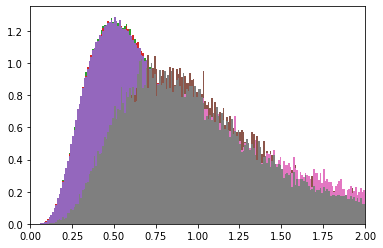

In [49]:
for in_file, out_file_waic, out_file_justloss, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist_waic,outputlist_justloss,exist_signalflag,is_signal, nprong):    
    
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    
    correct = (dt[:,0]>=2800)
    dt = dt[correct]   
    
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])



    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            dt = dt[sigidx]
        else:
            dt = dt[bkgidx]
            
    if n_prong == '2prong':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150) & (dt[:,0]>3400) & (dt[:,0]<3600)
        dt = dt[correct]
    
    if n_prong == '3prong':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>50) & (dt[:,19]<150) & (dt[:,0]>3400) & (dt[:,0]<3600)
        dt = dt[correct]    
        
    if n_prong == '4500':
        
        correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
        dt = dt[correct]  
    
    #Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    

    
            
    print(Y.shape)
    for i in range(12):
        Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]
    
    total_bb_test = torch.tensor(Y)
    model.eval()
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file_waic,waic)
    np.save(out_file_justloss,sigae_bbloss)

In [50]:
bkg_mean

[229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

In [51]:
bkg_std

[131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]

In [52]:
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",

('../data_strings/bkg_rndbkg_12features_mjjcut_MSELoss_beta1_z8f1_WAICloss_rndbkg.npy',)

In [53]:
loss_prong3 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")
loss_purebkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")
loss_4500 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy")



In [54]:
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy"

'../data_strings/bkg_rndbkg_12features_mjjcut_MSELoss_beta1_z8f1_Justloss_4500.npy'

In [55]:
ae_def

{'type': 'bkg',
 'trainon': 'rndbkg',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjjcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f1'}

In [56]:
loss_4500

array([0.500607  , 0.45028985, 0.5987567 , ..., 0.6106272 , 0.58294433,
       0.550126  ], dtype=float32)

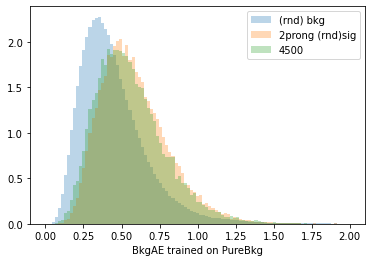

In [71]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong3,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='3prong (rnd)sig');
plt.hist(loss_4500,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='4500');

#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

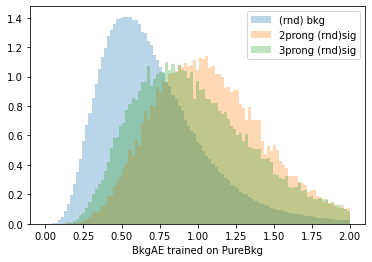

In [94]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

In [64]:
def reconstruct(X):
    out = model(torch.tensor(X[:100000]).float().cuda())[0]
    out = out.data.cpu().numpy()
    return out

In [65]:
out = reconstruct(Y)

In [66]:
out.shape

(100000, 12)

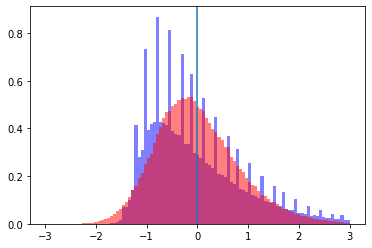

In [78]:
bins = np.linspace(-3,3,100)
bins.shape
column = 11
#print(df.coluns[column])
plt.hist(Y[:,column],bins,density=True,alpha=0.5,color='b');
plt.hist(out[:,column],bins,density=True,alpha=0.5,color='r');
plt.axvline(np.mean(Y[:,column]))

In [ ]:
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5')

In [ ]:
dt = f_bb.values

In [ ]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]
Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [ ]:
Y.shape

In [ ]:
idx = dt[:,-1]
sigidx = idx == 1
bkgidx = idx == 0

In [ ]:
for i in range(24):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

In [ ]:
Y = Y[sigidx]

In [ ]:
#correct = Y[:,0] > 300 #(For 2prong)
correct = Y[:,0] > 400 # (for 3prong)

In [ ]:
Y = Y[correct]

In [ ]:
Y.shape

In [ ]:
plt.hist(Y[:,0],bins=np.linspace(0,1000,1001));

In [ ]:
np.mean(Y[:,0])

In [ ]:
total_bb_test = torch.tensor(Y)
bkgae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [ ]:
bkgae_bbloss

In [ ]:
plt.hist(bkgae_bbloss,bins=np.linspace(0,10,1001));

In [ ]:
np.save('../data_strings/bkgae_rndbkg_loss_3prong.npy',bkgae_bbloss)

In [ ]:
loss_prong3 = np.load('../data_strings/bkgae_purebkg_loss_3prong.npy')
loss_prong2 = np.load('../data_strings/bkgae_purebkg_loss_2prong.npy')
loss_purebkg = np.load('../data_strings/bkgae_purebkg_loss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/bkgae_purebkg_loss_rndbkg.npy')

In [ ]:
len(loss_purebkg)

In [ ]:
len(loss_prong2)

In [ ]:
plt.hist(loss_purebkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_purebkg)),alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_rndbkg))*(len(loss_purebkg)/len(loss_rndbkg)),alpha=0.3,label='(rnd) bkg');

#plt.hist(loss_prong3,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong3))*(len(loss_purebkg)/len(loss_prong3)),alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong2,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong2))*(len(loss_purebkg)/len(loss_prong2)),alpha=0.3,label='3prong (rnd)sig');
plt.yscale('log')
plt.xlabel('BkgAE trained on Pure Bkg')
plt.legend(loc='upper right')
plt.savefig('bkgae_trained_on_pure_bkg_onlybkg.png')

In [ ]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [ ]:
bb1_loss_bkg = get_loss(X_bb1)

In [ ]:
bb1_loss_bkg = np.array(bb1_loss_bkg,dtype=np.float)

In [ ]:
bb1_loss_bkg

In [ ]:
plt.hist(bb1_loss_bkg,bins=np.linspace(0,5,1001));

In [ ]:
np.save('../data_strings/bkgaeloss_bb1.npy',bb1_loss_bkg)

In [ ]:
f_bb2 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5')
dt_bb2 = f_bb2.values

In [ ]:
X_bb2 = dt_bb2[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [ ]:
for i in range(12):
    X_bb2[:,i] = (X_bb2[:,i]-bkg_mean[i])/bkg_std[i]

In [ ]:
bb2_loss_bkg = get_loss(X_bb2)

In [ ]:
bb2_loss_bkg = np.array(bb2_loss_bkg,dtype=np.float)

In [ ]:
plt.hist(bb2_loss_bkg,bins=np.linspace(0,5,1001));

In [ ]:
f_bb3 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5')
dt_bb3 = f_bb3.values

In [ ]:
X_bb3 = dt_bb3[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [ ]:
for i in range(12):
    X_bb3[:,i] = (X_bb3[:,i]-bkg_mean[i])/bkg_std[i]

In [ ]:
bb3_loss_bkg = get_loss(X_bb3)

In [ ]:
bb3_loss_bkg = np.array(bb3_loss_bkg,dtype=np.float)

In [ ]:
bb3_loss_bkg

In [ ]:
plt.hist(bb3_loss_bkg,bins=np.linspace(0,5,1001));

In [ ]:
np.save('../data_strings/bkgaeloss_bb2.npy',bb2_loss_bkg)

In [ ]:
np.save('../data_strings/bkgaeloss_bb3.npy',bb3_loss_bkg)

In [ ]:
X[signal_idx].shape

In [ ]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,0.5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)